In [1]:
import sys, os, shutil, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K
import keras

Using TensorFlow backend.


In [2]:
def stock_prices(mu=0.01, sigma=0.3, S0=5, T=1, T_past=0, num_samples=50, num_steps=100):
    S=np.zeros([num_samples, num_steps+1])
    S[:,0]=S0
    dt=T/num_steps
    sqrt_dt=np.sqrt(dt)
    
    num_past_steps=int(T_past // dt)
    Spast=np.zeros([num_samples, num_past_steps+1])
    Spast[:,0]=S0
    
    
    normal_sample=np.random.normal(0,1,[num_samples, num_steps])
    normal_sample_past=np.random.normal(0,1,[num_samples, num_past_steps])
    if (type(mu) is list) or (type(mu) is tuple):
        Mu=np.random.uniform(mu[0], mu[1], num_samples)
    else:
        Mu=mu
    if (type(sigma) is list) or (type(sigma) is tuple):
        Sigma=np.random.uniform(sigma[0], sigma[1], num_samples)
    else:
        Sigma=sigma
        
    for k in range(1,num_steps+1):
        S[:,k]=S[:,k-1] + Mu*S[:,k-1]*dt + Sigma*S[:,k-1]*normal_sample[:,k-1]*sqrt_dt
    for k in range(1,num_past_steps+1):
        Spast[:,k]=Spast[:,k-1] + Mu*Spast[:,k-1]*dt + Sigma*Spast[:,k-1]*normal_sample_past[:,k-1]*sqrt_dt
    Spast=Spast[:,1:]
    Spast=np.fliplr(Spast)
    S=np.hstack([Spast,S])
    
    timepoints=np.hstack([np.arange(-num_past_steps,0), np.array([0]), np.arange(1, num_steps+1)])*dt
    return S, timepoints 


def stock_prices_generator(mu=0.01, sigma=0.3, S0=5, T=1, T_past=0, num_samples=50, num_steps=100, maxgen=np.inf, randomseed=None, modelinput=False):
    if randomseed is not None:
        np.random.seed(randomseed)
    _, timepoints=stock_prices(mu, sigma, S0, T, T_past, num_samples, num_steps)
    timepoints=np.ones((num_samples,1)).dot(timepoints.reshape(1,-1))
    
    k=0
    while k<maxgen:
        k=k+1
        S, _=stock_prices(mu, sigma, S0, T, T_past, num_samples, num_steps)
        if modelinput:
            yield [np.expand_dims(S, axis=2), np.expand_dims(timepoints, axis=2)], np.expand_dims(S, axis=2)
        else:
            yield S
        

In [3]:
num_past_steps=3
num_steps=5
np.hstack([np.arange(-num_past_steps,0), np.array([0]), np.arange(1, num_steps+1)])

array([-3, -2, -1,  0,  1,  2,  3,  4,  5])

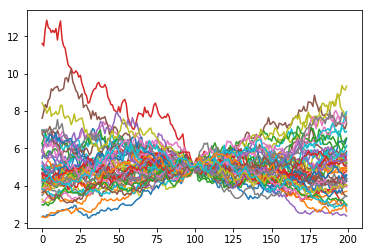

In [4]:
gen=stock_prices_generator(T_past=1)
plt.plot(gen.__next__().T)
plt.show()

In [5]:
gen.__next__().shape

(50, 200)

In [6]:
gen2=stock_prices_generator(modelinput=True, T_past=1)
out=gen2.__next__()
out[0][0].shape, out[0][1].shape, out[1].shape

((50, 200, 1), (50, 200, 1), (50, 200, 1))

In [7]:
def EuroOptionPrice_MonteCarlo(r=0.01, sigma=0.3, S0=5, T=1, K=5, Type='call', num_samples=50, num_steps=100):
    S, _=stock_prices(mu=r, sigma=sigma, S0=S0, T=T, T_past=0, num_samples=num_samples, num_steps=num_steps)
    if Type=='call':
        return np.maximum(S[:,-1]-K,0).mean()
    elif Type=='put':
        return np.maximum(K-S[:,-1],0).mean()
    else:
        raise ValueError('Invalid option Type: vslid options are "call" or "put".')
    

In [8]:
EuroOptionPrice_MonteCarlo(num_samples=10000, num_steps=100)

0.6223080401150897

In [9]:
EuroOptionPrice_MonteCarlo(num_samples=10000, num_steps=100, Type='put')

0.5778504340302796

check https://goodcalculators.com/black-scholes-calculator/

In [10]:
def AmericanOptionLSTM(timesteps,LSTM=False, units=20):
    stock_prices=keras.layers.Input(shape=(timesteps+1,1), name='Stock_prices')
    timepoints=keras.layers.Input(shape=(timesteps+1,1), name='Timepoints')
    
    x=stock_prices
    if LSTM:
        x=keras.layers.LSTM(units=units, return_sequences=True, name='LSTM1', activation='hard_sigmoid')(x)
    else:
        x=keras.layers.Conv1D(filters=units, kernel_size=1, name='FC1-Conv', activation='hard_sigmoid')(x)
    x=keras.layers.Concatenate(axis=2, name='ConcatTime')([x,timepoints])
    if LSTM:
        x=keras.layers.LSTM(units=1, return_sequences=True, name='LSTM2', activation='hard_sigmoid')(x)
    else:
        x=keras.layers.Conv1D(filters=1, kernel_size=1,name='FC2-Conv', activation='hard_sigmoid')(x)
    #x=keras.layers.Conv1D(filters=2,kernel_size=1)(x)
    outputs=x
    return keras.models.Model(inputs=[stock_prices, timepoints], outputs=outputs)

In [11]:
network=AmericanOptionLSTM(100, LSTM=False)
network.compile(loss='mean_squared_error', optimizer='sgd')

In [12]:
network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Stock_prices (InputLayer)       (None, 101, 1)       0                                            
__________________________________________________________________________________________________
FC1-Conv (Conv1D)               (None, 101, 20)      40          Stock_prices[0][0]               
__________________________________________________________________________________________________
Timepoints (InputLayer)         (None, 101, 1)       0                                            
__________________________________________________________________________________________________
ConcatTime (Concatenate)        (None, 101, 21)      0           FC1-Conv[0][0]                   
                                                                 Timepoints[0][0]                 
__________

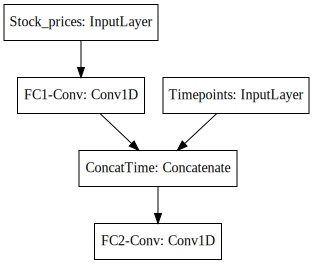

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(network, show_shapes=False, show_layer_names=True).create(prog='dot', format='svg'))

In [14]:
gen2=stock_prices_generator(modelinput=True)
network.fit_generator(gen2, epochs=5, steps_per_epoch=5)

Epoch 1/5
5/5 [==============================] - 1s 119ms/step - loss: 20.9079
Epoch 2/5
5/5 [==============================] - 0s 10ms/step - loss: 19.1535
Epoch 3/5
5/5 [==============================] - 0s 14ms/step - loss: 17.2149
Epoch 4/5
5/5 [==============================] - 0s 10ms/step - loss: 16.5829
Epoch 5/5
5/5 [==============================] - 0s 12ms/step - loss: 17.2370


In [17]:
X,y=gen2.__next__()
network.predict(X)

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [18]:
y

array([[[5.        ],
        [5.11593238],
        [5.1520442 ],
        ...,
        [6.90399155],
        [7.15190631],
        [7.1367828 ]],

       [[5.        ],
        [5.004345  ],
        [4.99885678],
        ...,
        [2.83549818],
        [2.74875697],
        [2.76311093]],

       [[5.        ],
        [4.85783244],
        [4.86389178],
        ...,
        [4.06143149],
        [3.88360885],
        [3.89349095]],

       ...,

       [[5.        ],
        [4.97348712],
        [5.07556723],
        ...,
        [7.57739004],
        [7.79330037],
        [7.51967641]],

       [[5.        ],
        [4.98319785],
        [4.90083348],
        ...,
        [8.8527996 ],
        [8.80234325],
        [9.04690076]],

       [[5.        ],
        [4.94871318],
        [4.85153532],
        ...,
        [4.19592059],
        [4.04084242],
        [4.09542862]]])

In [16]:
from keras.utils import plot_model
import matplotlib.image as mpimg
path='/home/igor/Desktop/model.png'

plot_model(network, to_file='/home/igor/Desktop/model.png', show_shapes=True, show_layer_names=False)